In [3]:
include("./runSim.jl")
pwd()

"/home/javier/Projects/DiffSolver"

In [6]:
α₁, _ = genInitialCond(512, 5, true)
gMx, gMy = gen_op(size(α₁,1), true)        # This generates the discrete laplacian as in CR's tutorial
r1 = 1.0/400.0
Dd = 1.0
if true
    gMyA = CuArray(Float32.(zeros(size(gMx))))
    gAMx = CuArray(Float32.(zeros(size(gMx))))
    gDA = CuArray(Float32.(zeros(size(gMx))))
else
    gMyA = zeros(size(gMx))
    gAMx = zeros(size(gMx))
    gDA = zeros(size(gMx))
end
u0 = α₁

512×512 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0

In [7]:
function genTuples(idx, in_cond, dist, use_gpu; s=100, radius=5, tmax=3000.0,
            dir = "newdata")
  α₁ = in_cond
  u0 = α₁
  if use_gpu
      prob = ODEProblem{false}(f,u0,(0.0,tmax),α₁)
#       @time sol = solve(prob,ROCK2(),progress=true,save_everystep=true,save_start=true)
    sol = solve(prob,ROCK2(),progress=true,save_everystep=true,save_start=true)
  else
      prob = ODEProblem{false}(fCPU,u0,(0.0,tmax),α₁)
#       @time sol = solve(prob,ROCK2(),save_everystep=false,save_start=false, abstol = 1e-3, reltol = 1e-3)
    sol = solve(prob,ROCK2(),save_everystep=false,save_start=false, abstol = 1e-3, reltol = 1e-3)
  end
  out = Array(sol[end])/maximum(sol[end])    #radius^2

#   path = PATH * dir * "/test2"   # temp: remove test2
#   isdir(path) || mkpath(path)
#   writedlm(path * "/Cell_$idx.dat", reshape(Array(α₁),:))
#   writedlm(path * "/Field_$idx.dat", reshape(out,:))
  # writedlm(path * "/Dist_$idx.dat", dist)
  Array(α₁), out
end

function runFunction(start, stop, dir; ns=1, gridSize=100, radius = 5)
  for i in start:stop
    @info i
    in_cond, dist = genInitialCond(gridSize, r, use_gpu; ns=ns)
    init_cond, final_state = genTuples(i, in_cond, dist, use_gpu; dir=dir)
    # f1 = heatmap(init_cond)
    # f2 = heatmap(final_state)
    # fig = plot(f1,f2, layout = @layout grid(2,1))
    # display(fig)
    CUDA.reclaim()
    if log
        flush(io)
    end
  end
end

runFunction (generic function with 1 method)

In [27]:
function genInitialCond(s, radius, use_gpu; ns=1, pos=[50 50])
  ar = [[i,j] for i in 1:s, j in 1:s]
  dist = zeros(ns)
  init_cond = zeros(s,s)
  for ns0 in 1:ns
    if size(pos,1) != 0
        source = [pos[ns0,1], pos[ns0,2]]
    else
        source = [rand(radius:s-radius), rand(radius:s-radius)]
    end
    dist[ns0] = min_dist_to_border(source, s)
    init_cond = init_cond .+ [in_source(ar[i,j][1], source[1], ar[i,j][2], source[2], radius) for i in 1:s, j in 1:s] .* rand(0.01:0.0000001:1.0)
  end

  if use_gpu
      CuArray{Float32,2}(init_cond/maximum(init_cond)), dist
  else
      init_cond/maximum(init_cond), dist
  end
#   CuArray{Float32,2}(min.(init_cond,1.0)), dist
end

genInitialCond (generic function with 1 method)

In [76]:
256-94

162

In [146]:
in_cond, dist = genInitialCond(512, 14, true; ns=9, pos=[256 256; 306 306; 212 306; 212 212; 312 212; 256 326; 256 196; 326 256; 196 256])
a,b = genTuples(1, in_cond, dist, true)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[4.1162887f-10 8.1786455f-10 … 1.1611663f-9 5.836494f-10; 8.180889f-10 1.6363693f-9 … 2.3167792f-9 1.1609287f-9; … ; 4.775336f-10 9.563941f-10 … 2.1264919f-9 1.0615302f-9; 2.3777783f-10 4.7793636f-10 … 1.061166f-9 5.3331817f-10])

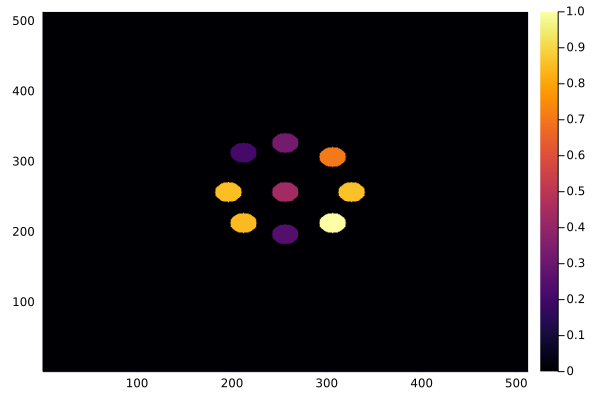

In [147]:
heatmap(Array(a))

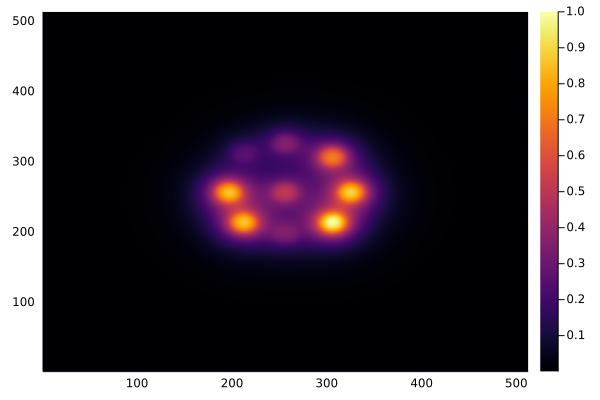

In [148]:
heatmap(Array(b))